In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import ipywidgets
from plot_utils import get_model_names_for_degree

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

../models/kernel_linear_regression/old
../models/kernel_linear_regression/model1
../models/kernel_linear_regression/small-1-11-5M-steps
../models/lora/7f3d8135-fcb1-4f82-bed6-041508e56589
../models/lora/f214d84d-3dad-4326-aa86-5dd04b09ae53
../models/soft_prompting/6da1d7cd-bc48-4b91-9809-c0e0e59ecd06
../models/soft_prompting/49c6a6c8-435d-4096-a5a9-45d86c10fd23
['chebyshev_linear_regression_toy' 'curriculum' 'lora_testing_degree'
 'lora_testing_shared_roots' 'prompting_degree' 'prompting_shared_roots']
                                 run_id                      task  \
2                   small-1-11-5M-steps  kernel_linear_regression   
0                                   old  kernel_linear_regression   
1                                model1  kernel_linear_regression   
3  7f3d8135-fcb1-4f82-bed6-041508e56589                      lora   
4  f214d84d-3dad-4326-aa86-5dd04b09ae53                      lora   
6  49c6a6c8-435d-4096-a5a9-45d86c10fd23            soft_prompting   
5  6da1d7

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
2,small-1-11-5M-steps,kernel_linear_regression,Transformer-small,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,6,4,chebyshev_linear_regression_toy
0,old,kernel_linear_regression,Transformer-plus,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,24,16,curriculum
1,model1,kernel_linear_regression,Transformer-plus,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,24,16,curriculum
3,7f3d8135-fcb1-4f82-bed6-041508e56589,lora,lora_testing_degree,basis_dim=5_different_degrees=False_highest_de...,-1,-1,1,6,4,lora_testing_degree
4,f214d84d-3dad-4326-aa86-5dd04b09ae53,lora,lora_testing_shared_roots,basis_dim=5_degree=5,-1,-1,1,6,4,lora_testing_shared_roots
6,49c6a6c8-435d-4096-a5a9-45d86c10fd23,soft_prompting,prompting_degree,basis_dim=5_different_degrees=False_highest_de...,-1,-1,1,6,4,prompting_degree
5,6da1d7cd-bc48-4b91-9809-c0e0e59ecd06,soft_prompting,prompting_shared_roots,basis_dim=5_degree=5,-1,-1,1,6,4,prompting_shared_roots


In [7]:
task = "kernel_linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "7f3d8135-fcb1-4f82-bed6-041508e56589"  # if you train more models, replace with the run_id from the table above
#run_id = "lr_00005"
run_path = os.path.join(run_dir, "lora", run_id)

run_id2 = "f214d84d-3dad-4326-aa86-5dd04b09ae53"  # if you train more models, replace with the run_id from the table above
#run_id = "lr_00005"
run_path2 = os.path.join(run_dir, "lora", run_id2)


run_id_big = "small-1-11-5M-steps"
run_path_big = os.path.join(run_dir, task, run_id_big)

#run_id_noise_2 = "0.25x-micro-no-noise-batch-8192-basis-1-4-500k"
#run_path_noise_2 = os.path.join(run_dir, task, run_id_noise_2) 


#run_path = '/home/riadoshi/CS182Project/models/kernel_linear_regression/cde31f7a-93a0-4aa6-b833-37e178b50ae4' # enter the path to the downloaded checkpoint here
metrics = get_run_metrics(run_path, run_path_big, run_path2, include_noise=False, ground_truth_loss=False, smoothing=0.00, step=4000)  # these are normally precomputed at the end of training
#metrics = get_run_metrics(run_path, step=4000, cache=False, include_noise=False)


../models/lora/7f3d8135-fcb1-4f82-bed6-041508e56589
Non-tranaible parameters: 7633280
Trainable parameters: 172417


/home/ubuntu/mydata/miniconda3/envs/in-context-learning2/lib/python3.8/site-packages/peft/tuners/lora/layer.py:1059: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


../models/kernel_linear_regression/small-1-11-5M-steps
../models/lora/f214d84d-3dad-4326-aa86-5dd04b09ae53
Non-tranaible parameters: 7633280
Trainable parameters: 172417


# Plot pre-computed metrics

../models
Valid row?: False kernel_linear_regression small-1-11-5M-steps
Valid row?: False kernel_linear_regression old
Valid row?: False kernel_linear_regression model1
Valid row?: True lora 7f3d8135-fcb1-4f82-bed6-041508e56589
../models/lora/7f3d8135-fcb1-4f82-bed6-041508e56589
lora_testing_degree 7f3d8135-fcb1-4f82-bed6-041508e56589
../models/lora/7f3d8135-fcb1-4f82-bed6-041508e56589
Non-tranaible parameters: 7633280
Trainable parameters: 172417


/home/ubuntu/mydata/miniconda3/envs/in-context-learning2/lib/python3.8/site-packages/peft/tuners/lora/layer.py:1059: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Metrics: {'degree-4': {'chebyshev_4_driver=None': {'mean': [1.2660465240478516, 0.7101417779922485, 0.5217772722244263, 0.32661232352256775, 0.114506796002388, 2.539681736379862e-05, 1.6405570235633604e-09, 1.358715029375901e-09, 1.2956884176684724e-10, 4.980531542742028e-10, 2.646934321032246e-13, 2.582061626142662e-13, 4.1473318242125565e-14, 3.6836212655459374e-14, 5.265587445235642e-12, 1.1257778699058987e-13, 1.0951247639843023e-13, 3.2449906748211604e-14, 2.833454974013154e-14, 2.87172798832825e-14, 3.334570168817344e-14, 2.758102414805643e-14, 4.046682964848475e-14, 4.8422203746678605e-14, 4.1635318375485633e-14, 2.7593585646664212e-14, 1.9557982281772322e-14, 1.596974573522987e-14, 2.5357108651854164e-14, 7.558114968305232e-14, 2.6043896518015107e-14], 'std': [1.8932545185089111, 1.4199146032333374, 1.2806493043899536, 1.0428581237792969, 0.7245934009552002, 0.0008812769665382802, 5.031667882349211e-08, 4.047408097562766e-08, 4.139232956390515e-09, 1.7748106984072365e-08, 3.547

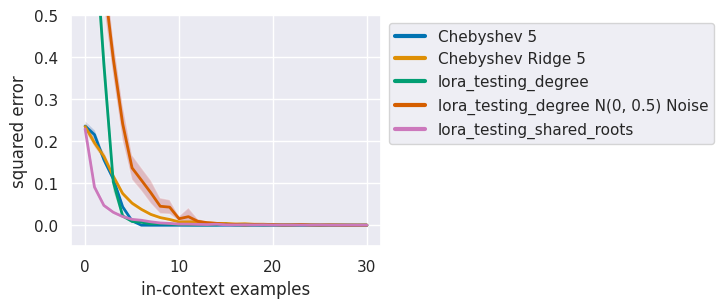

In [10]:
def valid_row(r, run_id):
    return r.task == "lora" and (r.run_id == run_id or r.run_id == run_id2)

print(run_dir)
metrics = collect_results(run_dir, df, valid_row=lambda x: valid_row(x, run_id), smoothing=0.00, step=4000)

#metrics_smooth = collect_results(run_dir, df, valid_row=lambda x: valid_row(x, run_id), smoothing=0.01)
#metrics_big = collect_results(run_dir, df, valid_row= lambda x: valid_row(x, run_id_big), smoothing=0.00)
_, conf = get_model_from_run(run_path, only_conf=True, step=4000)
n_dims = conf.model.n_dims

#for k, v in metrics_big.items():
#    for k2, v2 in v.items():
#        if "Transformer" in k2:
#            metrics[k][k2] = v2
#for k, v in metrics_smooth.items():
#    for k2, v2 in v.items():
#        if "Transformer" in k2:
#            metrics[k][k2+ " Smoothed"] = v2

ylims = [2, 2, 0.2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
for degree in range(5, 6):
    models = get_model_names_for_degree(degree)
    #print(models)
    #print(metrics.keys())
    #print(metrics["degree-" + str(degree)].keys())
    basic_plot(metrics["degree-" + str(degree)], models=models, ylim=ylims[degree-1])
    #plt.title("Loss for polynomial degree " + str(degree))
    plt.savefig("graphs/degree-" + str(degree) + ".png", dpi=300, bbox_inches='tight')
    plt.show()